# Setup

## install

In [1]:
!pip install langchain langchain_openai langchain_community langchain_huggingface faiss-cpu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.3/55.3 kB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 19.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 37.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.7/30.7 MB 15.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 415.1/415.1 kB 22.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 20.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 35.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 31.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 35.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.

In [2]:
# !pip install -U langchain langchain-community langchain-experimental langchain-core langchain_huggingface langchain-openai langsmith langchainhub pymupdf sentence-transformers faiss-cpu pypdf

## OpenAI Key 등록
- [OpenAI Key 발급](https://platform.openai.com/api-keys)
- [OpenAI 요금](https://openai.com/api/pricing/)

In [ ]:
import os

os.environ['OPENAI_API_KEY'] = 'sk-'


## 구글 드라이브 연결

In [4]:
# 구글 드라이브 연결(데이터 로드를 위해서)
try:
    from google.colab import drive

    drive.mount('/content/data')
    DATA_PATH = "/content/data/MyDrive/ai_lecture/5. Large Language Models/data/"
except:
    DATA_PATH = "./data/"

Mounted at /content/data


# [Reranker](https://python.langchain.com/docs/integrations/retrievers/)
- Reranker(리랭커)는 현대적인 두 단계 검색 시스템(Two-Stage Retrieval System)에서 사용되는 핵심 컴포넌트입니다. 대규모 데이터셋에서 효율적이고 정확한 검색을 수행하기 위해 설계되었으며, 주로 첫 번째 단계인 Retriever가 찾아낸 문서들의 순위를 재조정하는 역할을 합니다.

## [Reranker가 필요한 이유](https://aws.amazon.com/ko/blogs/tech/korean-reranker-rag/)

먼저 현재 RAG의 문제점에 대해서 살펴보도록 하겠습니다. RAG는 수많은 텍스트 문서에서 의미론적 검색 (Semantic search) 과정을 수행합니다. 의미론적 검색에는 일반적으로 벡터 검색을 활용 되는데, 이 과정에서 두 가지 정보 손실이 발생하게 됩니다.
- `첫 번째는 문서의 임베딩 벡터 변환 과정에서의 손실입니다.` 임베딩 벡터 변환이란 문서를 n개의 숫자로 재 표현하는 것을 의미하는데, 정보의 손실은 문서가 긴 경우에 정해진 벡터의 차원으로 표현하기 어려울 때 발생하게 됩니다.
- `두 번째는 검색 과정에서의 손실입니다.` RAG는 검색 시간 단축을 위해 Approximate Nearnest Neighbor search (ANNs) 기술을 활용합니다. 이 방법은 질문과 문서 사이의 관련성 체크 횟수를 현저히 줄임으로써 검색속도를 높일 수 있습니다. 하지만 이 과정에서 발생하는 관련성 정확도 하락이 정보의 손실로 나타나게 됩니다. 이러한 정보 손실로 인해 LLM으로 전달되는 컨텍스트의 상위 k개 이내에서 질문에 대한 관련 정보가 누락되는 경우가 발생합니다.

- 이러한 문제는 검색 후 반환되는 문서수를 늘림 (k 증가) 으로써 간단히 해결할 수 있습니다. 하지만 이 방법은 LLM에 전달하는 컨텍스트가 늘어나기 때문에 비용 효율적이지 않습니다.
- 그 뿐만이 아닙니다. 최근 출판된 논문에 따르면 RAG의 정확도는 관련정보의 컨텍스트 내 존재 유무가 아닌, 순서라는 것을 발견하였습니다.

즉, 관련 정보가 컨텍스트 내 상위권에 위치하고 있을 때 좋은 답변을 얻을 수 있다는 뜻 입니다.

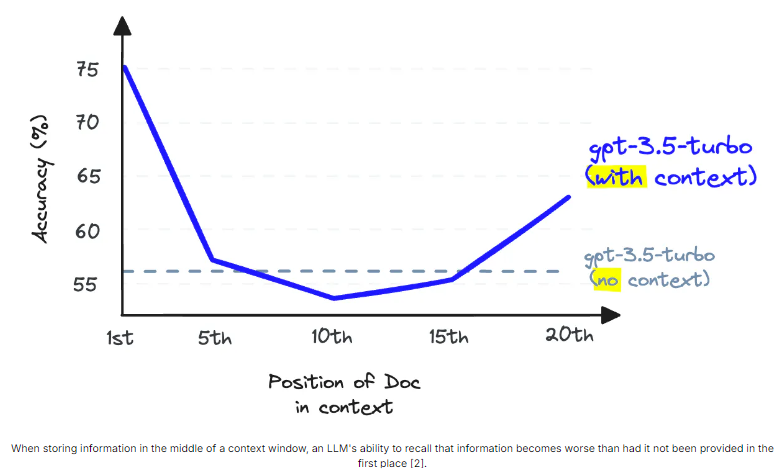

##[Power of Rerankers](https://www.pinecone.io/learn/series/rag/rerankers/)
- 기존에 벡터 검색을 위해 사용하는 구조가 `Bi-encoder`라면, `rerank`를 위한 구조는 `Cross-encoder`입니다.
- `Bi-encoder`는 질의와 정보를 각각 임베딩한 후 유사도를 계산합니다.
- `Cross-encoder`는 질의와 정보를 입력으로 사용하여 유사도를 출력합니다. 질의와 정보를 각각 입력하고 유사도를 얻는 `Bi-encoder`와 다르게 질의와 정보의 내용을 한번에 고려하기 때문에 더욱 정확한 유사도를 얻을 수 있다고 합니다. 이 유사도를 사용하여 질의와의 관련성에 따라 정보(문서)를 재정렬합니다.
- 하지만 `Cross-encoder`는 모든 조합들을 활용해 인풋으로 활용해야 하기 때문에, 비용이 높습니다. 때문에 일반적인 벡터 검색(`retrieval`)을 진행한 후, `reranker` 기반으로 순위를 재정렬하는 경우가 일반적입니다.


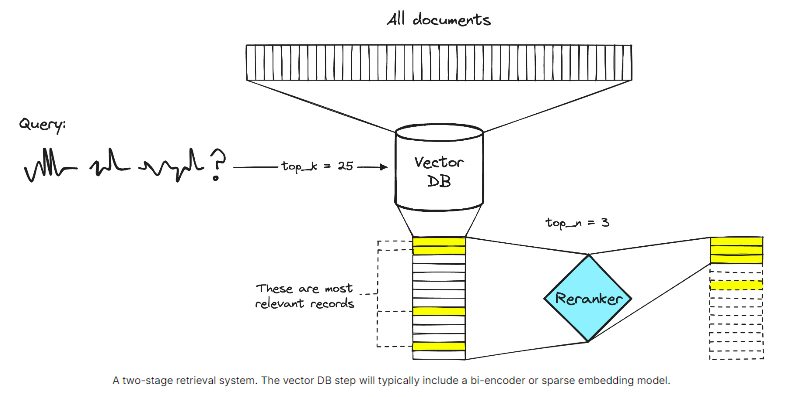

### Bi-encoder

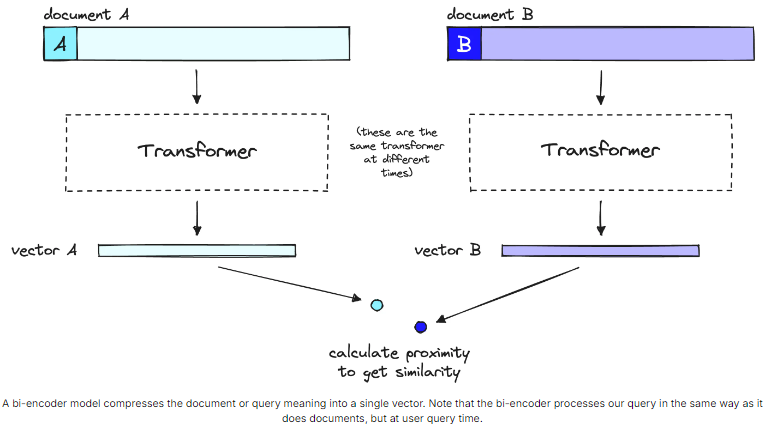

### Cross-encoder

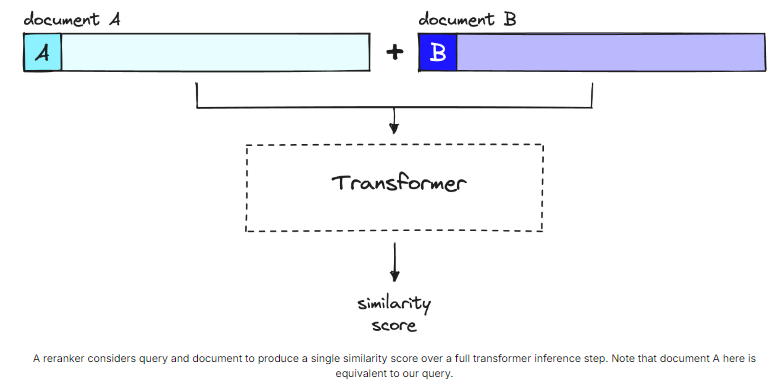

## Reranker 장단점

- 장점
  - 검색 정확도 크게 향상
  - 복잡한 의미적 관계 모델링 가능
  - 첫 단계 검색의 한계 보완
- 단점
  - 계산 비용 증가
  - 처리 시간 증가
  - 대규모 데이터셋에 직접 적용 어려움

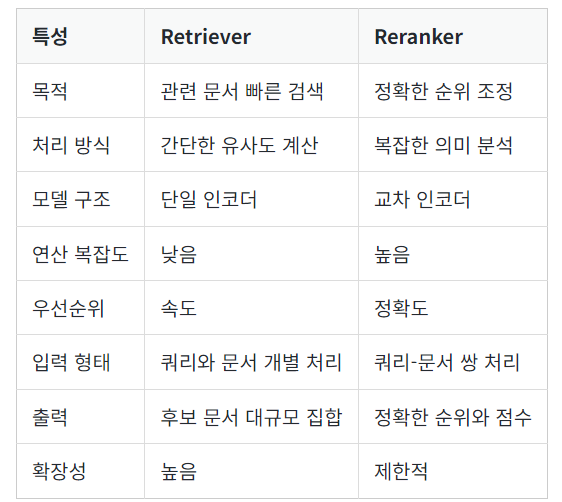

# Reranker 예제
- Cross encoder reranker는 검색 증강 생성(RAG) 시스템의 성능을 향상시키기 위해 사용되는 기술입니다. 이 문서는 Hugging Face의 cross encoder 모델을 사용하여 retriever에서 reranker를 구현하는 방법을 설명합니다.

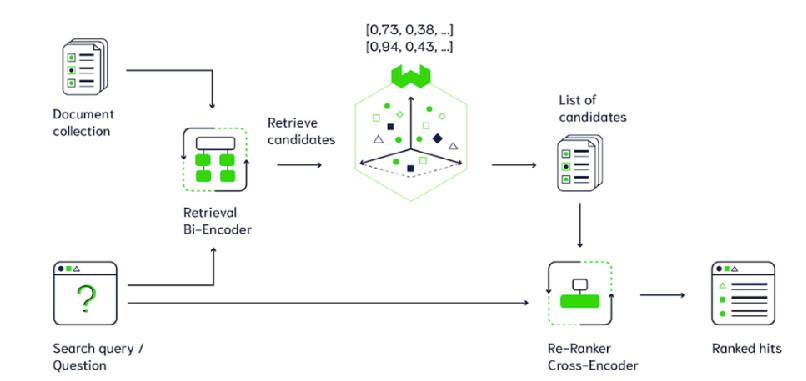

In [5]:
# 문서 출력 도우미 함수
def pretty_print_docs(docs):
    print(
        f"\n{'-' * 100}\n".join(
            [f"Document {i+1}:\n\n" + d.page_content for i, d in enumerate(docs)]
        )
    )

In [6]:
from langchain_community.document_loaders import TextLoader
from langchain_community.vectorstores import FAISS
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_text_splitters import RecursiveCharacterTextSplitter

## Vector DB

- 문서 로드

In [7]:
# 문서 로드
documents = TextLoader(DATA_PATH+"appendix-keywords.txt").load()

In [8]:
len(documents)

1

- 텍스트 분할기 설정

In [9]:
# 텍스트 분할기 설정
text_splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=100)

- 문서 분할

In [10]:
# 문서 분할
texts = text_splitter.split_documents(documents)

In [11]:
len(texts)

15

- 임베딩 모델 설정

In [12]:
# 임베딩 모델 설정
embeddingsModel = HuggingFaceEmbeddings(
    model_name="sentence-transformers/msmarco-distilbert-dot-v5"
)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/212 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/6.51k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/546 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/265M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/320 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling%2Fconfig.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [13]:
embeddingsModel

HuggingFaceEmbeddings(model_name='sentence-transformers/msmarco-distilbert-dot-v5', cache_folder=None, model_kwargs={}, encode_kwargs={}, multi_process=False, show_progress=False)

- 문서로부터 FAISS 인덱스 생성

In [14]:
vector_db = FAISS.from_documents(texts, embeddingsModel)

## [Cross-Encoder](https://medium.com/@mauryaanoop3/the-indispensable-reranker-a-deep-dive-into-optimizing-retrieval-in-retrieval-augmented-generation-a12793ee393c)
- Bi-Encoder
  - Vector DB를 이용한 유사도 결과값
- Cross-Encoder
  - CrossEncoder을 이용한 LLM의 예측값

### Retriever

- 검색기 설정

In [15]:
# 검색기 설정
retriever = vector_db.as_retriever(
    search_kwargs={"k": 10}
)

- 질의 설정

In [16]:
# 질의 설정
query = "Word2Vec 에 대해서 알려줄래?"

- 질의 수행 및 결과 문서 반환

In [17]:
# 질의 수행 및 결과 문서 반환
docs = retriever.invoke(query)

In [18]:
len(docs)

10

- 결과 문서 출력

In [19]:
# 결과 문서 출력
pretty_print_docs(docs)

Document 1:

Open Source

정의: 오픈 소스는 소스 코드가 공개되어 누구나 자유롭게 사용, 수정, 배포할 수 있는 소프트웨어를 의미합니다. 이는 협업과 혁신을 촉진하는 데 중요한 역할을 합니다.
예시: 리눅스 운영 체제는 대표적인 오픈 소스 프로젝트입니다.
연관키워드: 소프트웨어 개발, 커뮤니티, 기술 협업

Structured Data

정의: 구조화된 데이터는 정해진 형식이나 스키마에 따라 조직된 데이터입니다. 이는 데이터베이스, 스프레드시트 등에서 쉽게 검색하고 분석할 수 있습니다.
예시: 관계형 데이터베이스에 저장된 고객 정보 테이블은 구조화된 데이터의 예입니다.
연관키워드: 데이터베이스, 데이터 분석, 데이터 모델링

Parser
----------------------------------------------------------------------------------------------------
Document 2:

정의: LLM은 대규모의 텍스트 데이터로 훈련된 큰 규모의 언어 모델을 의미합니다. 이러한 모델은 다양한 자연어 이해 및 생성 작업에 사용됩니다.
예시: OpenAI의 GPT 시리즈는 대표적인 대규모 언어 모델입니다.
연관키워드: 자연어 처리, 딥러닝, 텍스트 생성

FAISS (Facebook AI Similarity Search)

정의: FAISS는 페이스북에서 개발한 고속 유사성 검색 라이브러리로, 특히 대규모 벡터 집합에서 유사 벡터를 효과적으로 검색할 수 있도록 설계되었습니다.
예시: 수백만 개의 이미지 벡터 중에서 비슷한 이미지를 빠르게 찾는 데 FAISS가 사용될 수 있습니다.
연관키워드: 벡터 검색, 머신러닝, 데이터베이스 최적화

Open Source
----------------------------------------------------------------------------------------------------
Document 3:

InstructGPT

정의: Ins

### CrossEncoder

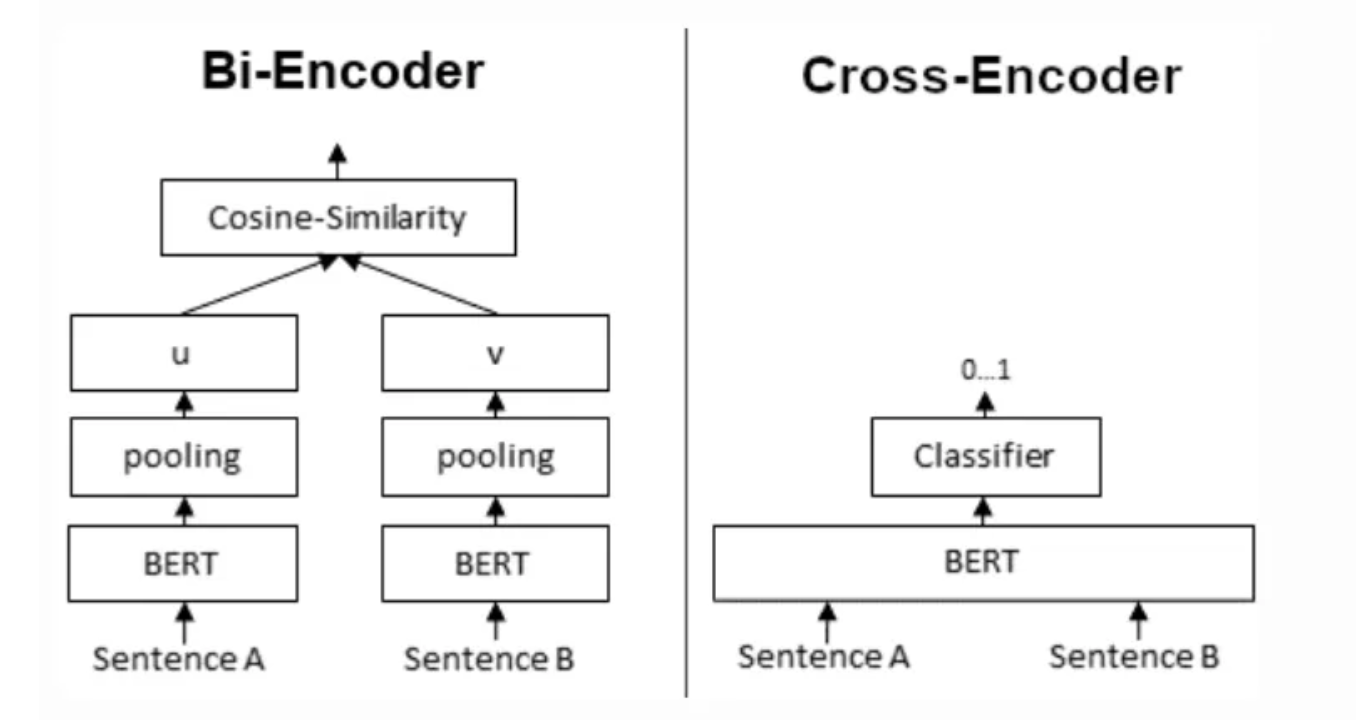

In [20]:
from sentence_transformers import CrossEncoder
cross_encoder = CrossEncoder(
    "Dongjin-kr/ko-reranker", max_length = 512, device="cpu"
)

config.json:   0%|          | 0.00/802 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.24G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/963 [00:00<?, ?B/s]

### Run

In [21]:
reranked_docs = cross_encoder.rank(
    query, # 사용자 질의
    [doc.page_content for doc in docs], # Retriever의 결과값
    top_k=3,
    return_documents=True,
)

In [22]:
# 문서 출력
print(
    f"\n{'-' * 100}\n".join(
        [f"Document {i+1}:\n\n" + d["text"] for i, d in enumerate(reranked_docs)]
    )
)

Document 1:

Crawling

정의: 크롤링은 자동화된 방식으로 웹 페이지를 방문하여 데이터를 수집하는 과정입니다. 이는 검색 엔진 최적화나 데이터 분석에 자주 사용됩니다.
예시: 구글 검색 엔진이 인터넷 상의 웹사이트를 방문하여 콘텐츠를 수집하고 인덱싱하는 것이 크롤링입니다.
연관키워드: 데이터 수집, 웹 스크래핑, 검색 엔진

Word2Vec

정의: Word2Vec은 단어를 벡터 공간에 매핑하여 단어 간의 의미적 관계를 나타내는 자연어 처리 기술입니다. 이는 단어의 문맥적 유사성을 기반으로 벡터를 생성합니다.
예시: Word2Vec 모델에서 "왕"과 "여왕"은 서로 가까운 위치에 벡터로 표현됩니다.
연관키워드: 자연어 처리, 임베딩, 의미론적 유사성
LLM (Large Language Model)
----------------------------------------------------------------------------------------------------
Document 2:

Semantic Search

정의: 의미론적 검색은 사용자의 질의를 단순한 키워드 매칭을 넘어서 그 의미를 파악하여 관련된 결과를 반환하는 검색 방식입니다.
예시: 사용자가 "태양계 행성"이라고 검색하면, "목성", "화성" 등과 같이 관련된 행성에 대한 정보를 반환합니다.
연관키워드: 자연어 처리, 검색 알고리즘, 데이터 마이닝

Embedding

정의: 임베딩은 단어나 문장 같은 텍스트 데이터를 저차원의 연속적인 벡터로 변환하는 과정입니다. 이를 통해 컴퓨터가 텍스트를 이해하고 처리할 수 있게 합니다.
예시: "사과"라는 단어를 [0.65, -0.23, 0.17]과 같은 벡터로 표현합니다.
연관키워드: 자연어 처리, 벡터화, 딥러닝

Token
----------------------------------------------------------------------------------------------------
Document 3:


## [CrossEncoderReranker](https://medium.com/@rhitesh.ksingh99/designing-rag-pipelines-using-langchain-and-evaluating-them-using-ragas-4e7d09262bac)
- 기본 retriever를 `ContextualCompressionRetriever`로 감싸보겠습니다. `CrossEncoderReranker`는 HuggingFaceCrossEncoder를 사용하여 반환된 결과를 재정렬합니다.
- 다국어 지원 BGE Reranker: `bge-reranker-v2-m3`

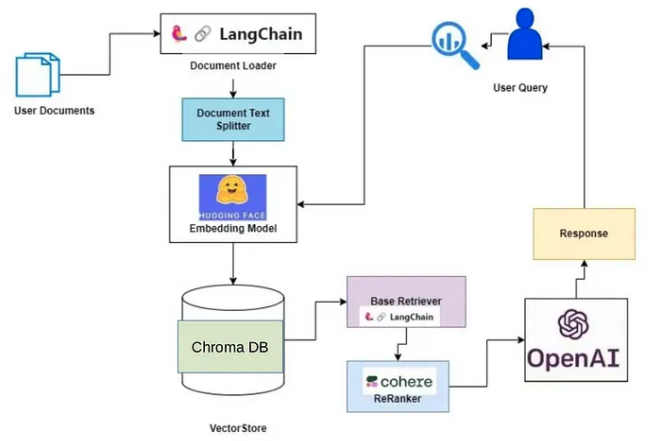

### CrossEncoderReranker

- HuggingFaceCrossEncoder

In [23]:
from langchain_community.cross_encoders import HuggingFaceCrossEncoder

# 모델 초기화
model = HuggingFaceCrossEncoder(model_name="BAAI/bge-reranker-v2-m3")

config.json:   0%|          | 0.00/795 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.27G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.17k [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/964 [00:00<?, ?B/s]

- CrossEncoderReranker

In [24]:
from langchain.retrievers.document_compressors import CrossEncoderReranker

# 상위 3개의 문서 선택
compressor = CrossEncoderReranker(model=model, top_n=3)

### ContextualCompressionRetriever

- MultiQueryRetriever

In [25]:
from langchain_openai import ChatOpenAI

# ChatOpenAI 언어 모델을 초기화합니다. temperature는 0으로 설정합니다.
llm = ChatOpenAI(temperature=0, model="gpt-4o-mini")

In [26]:
from langchain.retrievers.multi_query import MultiQueryRetriever

multi_query_retriever = MultiQueryRetriever.from_llm(
    retriever=vector_db.as_retriever(), llm=llm
)

- ContextualCompressionRetriever

In [27]:
from langchain.retrievers import ContextualCompressionRetriever

# 문서 압축 검색기 초기화
compression_retriever = ContextualCompressionRetriever(
    base_compressor=compressor, base_retriever=multi_query_retriever
)

### Run
- 압축된 문서 검색

In [28]:
# 질의 설정
query = "Word2Vec 에 대해서 알려줄래?"

# 압축된 문서 검색
compressed_docs = compression_retriever.invoke(query)

In [29]:
len(compressed_docs)

3

- 문서 출력

In [30]:
# 문서 출력
pretty_print_docs(compressed_docs)

Document 1:

Token

정의: 토큰은 텍스트를 더 작은 단위로 분할하는 것을 의미합니다. 이는 일반적으로 단어, 문장, 또는 구절일 수 있습니다.
예시: 문장 "나는 학교에 간다"를 "나는", "학교에", "간다"로 분할합니다.
연관키워드: 토큰화, 자연어 처리, 구문 분석

Tokenizer

정의: 토크나이저는 텍스트 데이터를 토큰으로 분할하는 도구입니다. 이는 자연어 처리에서 데이터를 전처리하는 데 사용됩니다.
예시: "I love programming."이라는 문장을 ["I", "love", "programming", "."]으로 분할합니다.
연관키워드: 토큰화, 자연어 처리, 구문 분석

VectorStore

정의: 벡터스토어는 벡터 형식으로 변환된 데이터를 저장하는 시스템입니다. 이는 검색, 분류 및 기타 데이터 분석 작업에 사용됩니다.
예시: 단어 임베딩 벡터들을 데이터베이스에 저장하여 빠르게 접근할 수 있습니다.
연관키워드: 임베딩, 데이터베이스, 벡터화

SQL
----------------------------------------------------------------------------------------------------
Document 2:

Open Source

정의: 오픈 소스는 소스 코드가 공개되어 누구나 자유롭게 사용, 수정, 배포할 수 있는 소프트웨어를 의미합니다. 이는 협업과 혁신을 촉진하는 데 중요한 역할을 합니다.
예시: 리눅스 운영 체제는 대표적인 오픈 소스 프로젝트입니다.
연관키워드: 소프트웨어 개발, 커뮤니티, 기술 협업

Structured Data

정의: 구조화된 데이터는 정해진 형식이나 스키마에 따라 조직된 데이터입니다. 이는 데이터베이스, 스프레드시트 등에서 쉽게 검색하고 분석할 수 있습니다.
예시: 관계형 데이터베이스에 저장된 고객 정보 테이블은 구조화된 데이터의 예입니다.
연관키워드: 데이터베이스, 데이터 분석, 데이터 모델링

Parser
--------------------

## [CohereRerank](https://python.langchain.com/docs/integrations/retrievers/cohere-reranker/)
- Cohere는 기업이 인간-기계 상호작용을 개선할 수 있도록 돕는 자연어 처리 모델을 제공하는 캐나다의 스타트업입니다.
- Cohere Rerank는 의미론적 콘텐츠, 사용자 의도, 문맥과의 관련성 등 추가 기준에 따라 검색된 문서의 관련성을 재평가하고 순서를 변경하여 유사성 점수를 산출하는 것을 목표로 합니다.
- 그런 다음 이 점수를 사용하여 쿼리의 관련성에 따라 문서를 재정렬합니다. 다음 이미지는 Rerank를 사용한 재정렬 결과를 보여줍니다.

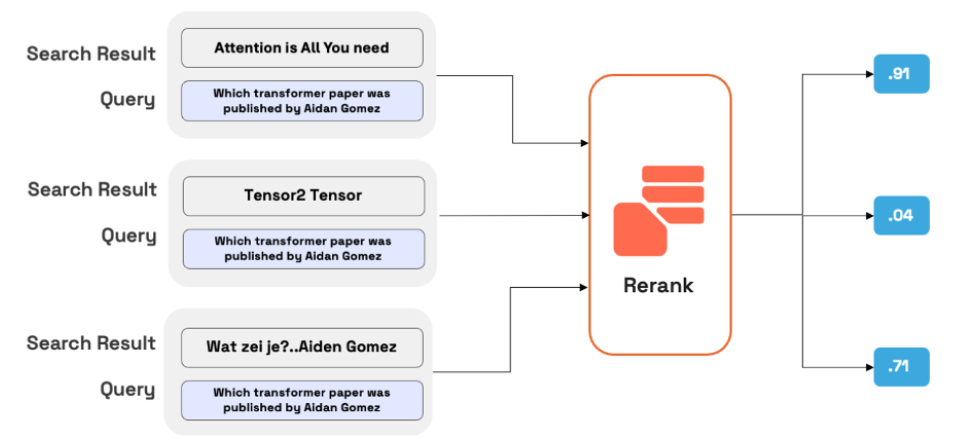

## [JinaRerank](https://python.langchain.com/docs/integrations/document_transformers/jina_rerank/)
- Weaviate Agents는 Weaviate의 벡터 데이터베이스와 LLM을 활용하여 데이터를 저장, 검색 및 변환합니다.
- 이 턴키 방식은 데이터 파이프라인에서 관리해야 할 단계가 줄어든다는 것을 의미합니다.
- 데이터를 쿼리, 변환 또는 개인화하든 에이전트에게 작업을 위임하면 운영 오버헤드를 대폭 줄이고 오류가 발생하기 쉬운 스크립트를 최소화하며 통찰력(또는 사용자 영향)을 더 빨리 얻을 수 있습니다.

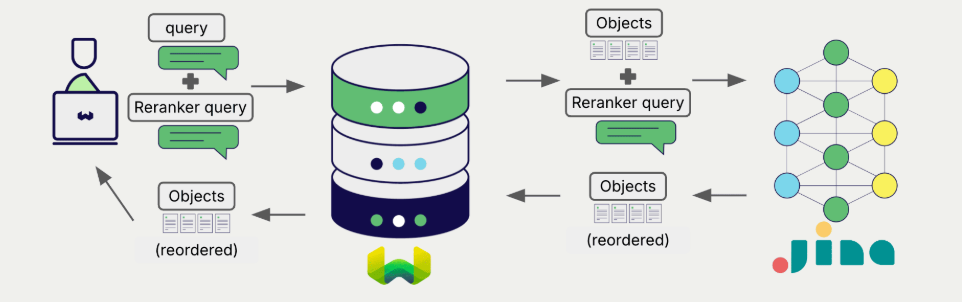